# Text Extractor Setting

In [1]:
%%bash
sudo apt install tesseract-ocr
pip install pytesseract

Reading package lists...
Building dependency tree...
Reading state information...
tesseract-ocr is already the newest version (4.1.1-2build2).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


# Library

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

import pytesseract
from pytesseract import Output

from PIL import Image
import cv2

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import TFBertModel

2024-03-02 17:10:12.173447: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-02 17:10:12.173539: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-02 17:10:12.309775: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# EDA Image

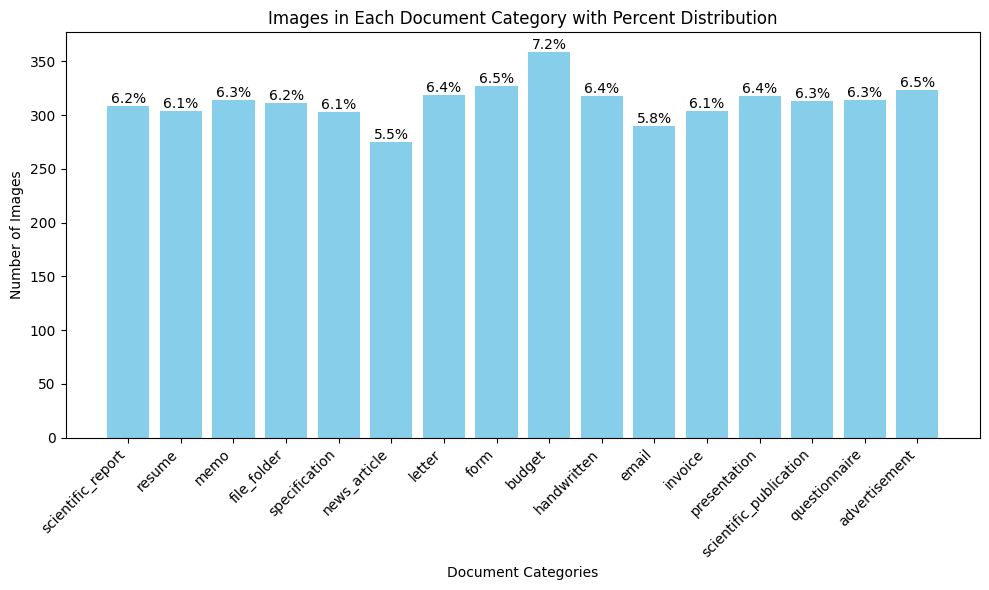

In [3]:
dataset_dir = "/kaggle/input/document-image/dataset"

classes = os.listdir(dataset_dir)

class_counts = {cls: 0 for cls in classes}

total_images = 0
for cls in classes:
    class_dir = os.path.join(dataset_dir, cls)
    num_images = len(os.listdir(class_dir))
    class_counts[cls] = num_images
    total_images += num_images

class_percentages = {cls: count / total_images * 100 for cls, count in class_counts.items()}

plt.figure(figsize=(10, 6))
bars = plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')

for bar in bars:
    height = bar.get_height()
    percentage = f'{height/total_images*100:.1f}%'
    plt.text(bar.get_x() + bar.get_width() / 2, height, percentage, ha='center', va='bottom')

plt.xlabel('Document Categories')
plt.ylabel('Number of Images')
plt.title('Images in Each Document Category with Percent Distribution')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

In [4]:
total_images = 0
classes = os.listdir(dataset_dir)

for cls in classes:
    class_dir = os.path.join(dataset_dir, cls)
    num_images = len(os.listdir(class_dir))
    total_images += num_images

print("Total number of images:", total_images)

Total number of images: 5000


In [5]:
img_paths = []
class_labels = []


for cls in classes:
    class_dir = os.path.join(dataset_dir, cls)

    for image_file in os.listdir(class_dir):

        image_path = os.path.join(class_dir, image_file)

        img_paths.append(image_path)
        class_labels.append(cls)

df = pd.DataFrame({'img_path': img_paths, 'class': class_labels})

In [7]:
df

,img_path,class
0,/kaggle/input/document-image/dataset/scientifi...,scientific_report
1,/kaggle/input/document-image/dataset/scientifi...,scientific_report
2,/kaggle/input/document-image/dataset/scientifi...,scientific_report
3,/kaggle/input/document-image/dataset/scientifi...,scientific_report
4,/kaggle/input/document-image/dataset/scientifi...,scientific_report
...,...,...
4995,/kaggle/input/document-image/dataset/advertise...,advertisement
4996,/kaggle/input/document-image/dataset/advertise...,advertisement
4997,/kaggle/input/document-image/dataset/advertise...,advertisement
4998,/kaggle/input/document-image/dataset/advertise...,advertisement


In [7]:
def get_image_shape(image_path):

    image = cv2.imread(image_path)
    if image is not None:
        height, width, channels = image.shape
        return height, width, channels
    else:
        return None

In [9]:
df[['height', 'width', 'channels']] = df['img_path'].apply(lambda x: pd.Series(get_image_shape(x)) if get_image_shape(x) is not None else (None, None, None))

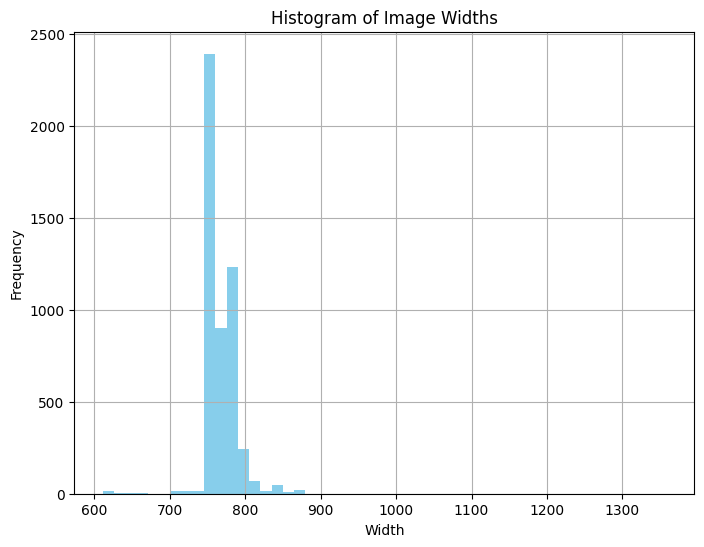

In [14]:
plt.figure(figsize=(8, 6))
plt.hist(df['width'], bins=50, color='skyblue')
plt.title('Histogram of Image Widths')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Data Preparation

## Extract Text (This proces is too longggg and pytesseract cannot work on GPU)

In [6]:
def text_from_image(image_path, language='eng'):
    config = '--psm 6'
    try:
        text = pytesseract.image_to_string(image_path, lang=language,config=config)
        return text
    except Exception as e:
        print("Error occurred:", e)
        return None

In [31]:
text_from_image("/kaggle/input/document-image/dataset/scientific_publication/scientific_publication253.jpg", language='eng')

'8\n\ni\n|\ni\n\n1S |\n\n8\n\n3\n\nXN\n\n-\n\n&\n\n3\n\nx\n\nx\n\x0c'

In [7]:
class_dataframes = {class_name: df[df['class'] == class_name].copy() for class_name in df['class'].unique()}

In [30]:
df_budget=class_dataframes['advertisement']
df_budget['text']=df_budget['img_path'].apply(lambda x: text_from_image(x))
df_budget.to_csv('advertisement.csv',index=False)

In [35]:
from IPython.display import FileLink
FileLink(r'all-prep.csv')

/kaggle/working/all-prep.csv

In [32]:
folder_path = '/kaggle/input/ocr-prep/ocr'

dataframes = []


for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        try:
            df = pd.read_csv(file_path)
            dataframes.append(df)
        except Exception as e:
            print(e)  

df = pd.concat(dataframes, ignore_index=True)


In [2]:
df.to_csv('all-prep.csv',index=False)

NameError: name 'df' is not defined

In [3]:
df=pd.read_csv('/kaggle/input/all-prep/all-prep.csv')

In [4]:
df.head()

,img_path,class,text
0,/kaggle/input/document-image/dataset/budget/bu...,budget,"LEQ BURNETT U.S.A:\nADVERTISING ""\naurooor est..."
1,/kaggle/input/document-image/dataset/budget/bu...,budget,g\n2 gs gal gl g Bgesgels = |g\ngj 8 8%) 3. S2...
2,/kaggle/input/document-image/dataset/budget/bu...,budget,THE TOBACCO INSTITUTE\n($000)\n1990 1991 _ % C...
3,/kaggle/input/document-image/dataset/budget/bu...,budget,een: y JE Pe POMC ae te Ree\nRS aa a 3 aes as ...
4,/kaggle/input/document-image/dataset/budget/bu...,budget,’ a\n“oe ri ss Invoice M = LMG\nLinda Garcia\n...


In [4]:
def load_and_resize_image(img_path):
    img_raw = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img_raw, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    return img

In [5]:
def zip_datasets(a, b, c):
    return tf.data.Dataset.zip((tf.data.Dataset.zip((a, b)), c))

In [6]:
def fit_vocabulary(texts, vocab_size=50000):
    vectorizer = tf.keras.layers.TextVectorization(max_tokens=vocab_size, output_mode='tf-idf')
    vectorizer.adapt(texts)
    return vectorizer

In [7]:
def create_input_pipeline(df, batch_size=32, is_training=False):
    image_ds = tf.data.Dataset.from_tensor_slices(df['img_path'].values)
    image_ds = image_ds.map(load_and_resize_image)
    
    text_ds = tf.data.Dataset.from_tensor_slices(df['text'].values)
    
    labels = [label_to_index[label] for label in df['class'].values]
    label_ds = tf.data.Dataset.from_tensor_slices(labels)


    ds = zip_datasets(image_ds, text_ds, label_ds)

    if is_training:
        ds = ds.shuffle(buffer_size=len(df)).repeat()

    ds = ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
    return ds

In [8]:
df_train, df_temp = train_test_split(df, test_size=0.3, stratify=df['class'], random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp['class'], random_state=42)

In [9]:
BATCH_SIZE = 32
IMG_SIZE = [512, 512]
CHANNELS = 3
VOCAB_SIZE = 50000
NUM_LABELS = 16
TRAIN_SIZE = 1500
VAL_SIZE = 500
unique_labels = sorted(df['class'].unique())
label_to_index = {label: index for index, label in enumerate(unique_labels)}

AUTOTUNE = tf.data.AUTOTUNE

In [10]:
vectorizer = fit_vocabulary(df_train['text'].values)

In [11]:
ds_train = create_input_pipeline(df_train, is_training=True)
ds_val = create_input_pipeline(df_val)
ds_test = create_input_pipeline(df_test)

test_y = df_test['class'].values
test_y_encoded = [label_to_index[label] for label in test_y]

In [12]:
def build_image_model():
    vgg19_model = tf.keras.applications.VGG19(
      input_shape=[IMG_SIZE[0], IMG_SIZE[1], CHANNELS],
      include_top=False, weights='imagenet')
    vgg19_model.trainable = True

    image_input = tf.keras.layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], CHANNELS))
    image_model = vgg19_model(image_input)

    image_features = tf.keras.layers.GlobalAveragePooling2D()(image_model)

    return image_input,image_features

In [13]:
def build_text_model():
    text_input = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
    text_model = vectorizer(text_input)
    text_model = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(text_model)
    return text_input,text_model

In [14]:
def multi_modal():
    
    image_input,image_model = build_image_model()
    text_input,text_model = build_text_model()


    combined = tf.keras.layers.concatenate([image_model, text_model])
    combined = tf.keras.layers.BatchNormalization()(combined)
    output = tf.keras.layers.Dense(NUM_LABELS, activation='softmax')(combined)

    model = tf.keras.Model(inputs=[image_input, text_input], outputs=output)

    return model

In [15]:
model = multi_modal()
model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg19 (Functional)  │ (None, 16, 16,    │ 20,024,384 │ input_layer_1[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 50000)     │          0 │ input_layer_2[0]… │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg19[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 50000)     │          0 │ text_vectorizati… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 50512)     │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 50512)     │    202,048 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │    808,208 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,034,640 (80.24 MB)

 Trainable params: 20,933,616 (79.86 MB)

 Non-trainable params: 101,024 (394.62 KB)

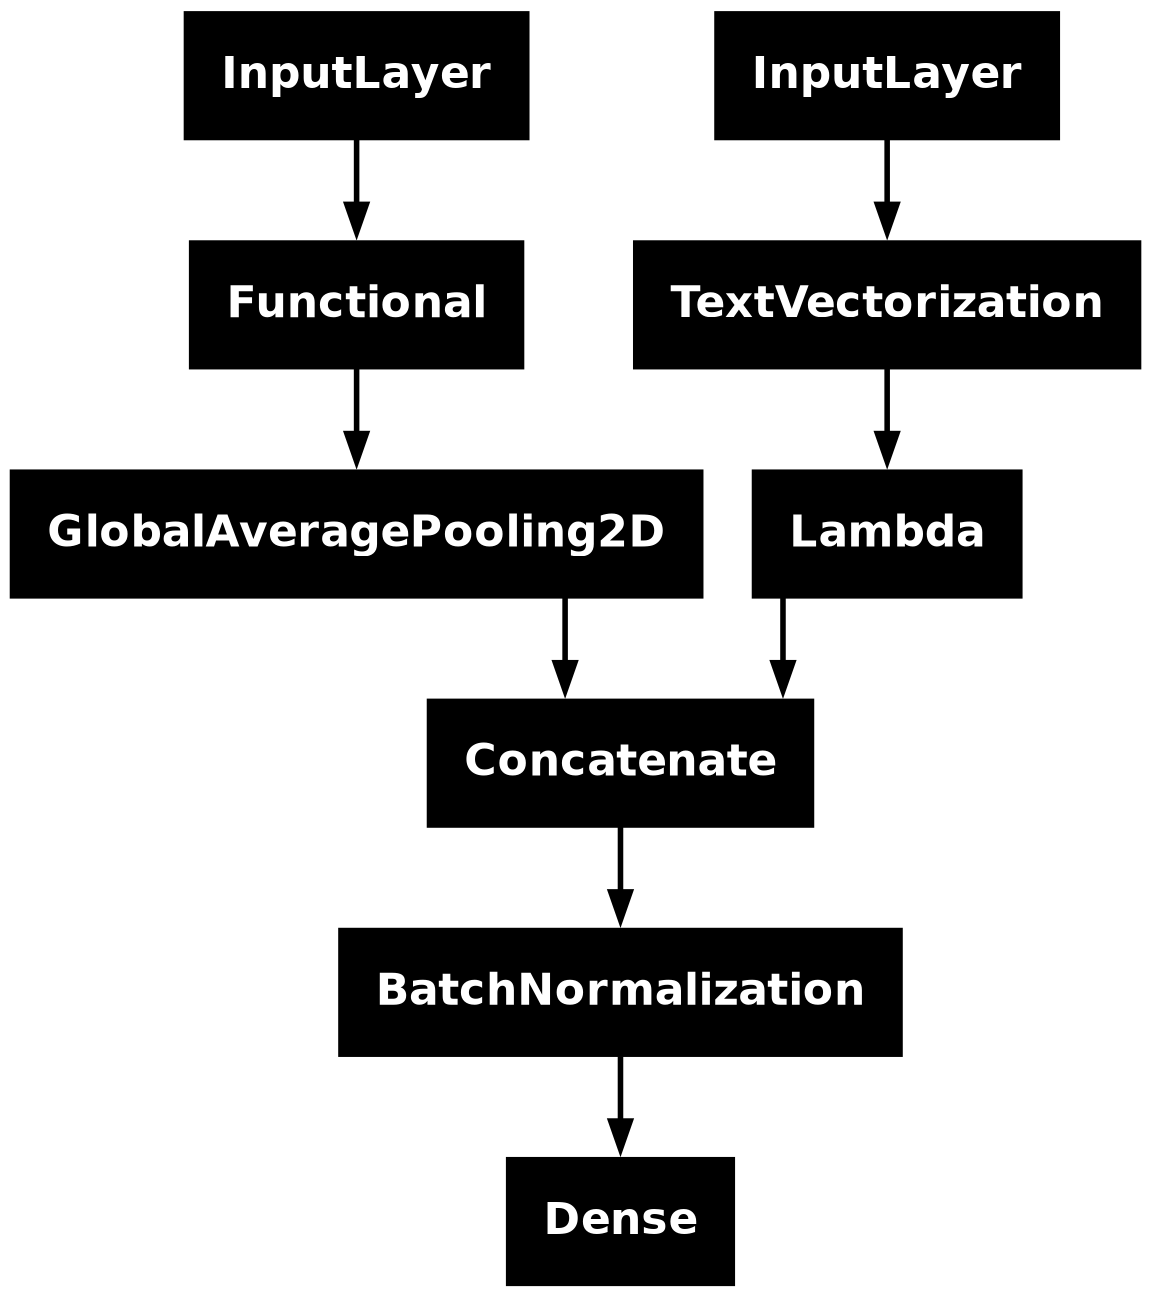

In [16]:
keras.utils.plot_model(model, show_layer_names=False)

In [17]:
steps_per_epoch=int(np.ceil(TRAIN_SIZE/BATCH_SIZE))

In [18]:
def create_callbacks(modelname,monitorvalue,mode):
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=modelname,
                             monitor=monitorvalue,
                             save_best_only=True)

    stop = tf.keras.callbacks.EarlyStopping(monitor=monitorvalue, 
                     mode=mode,
                     patience=10,
                     verbose=1, 
                     restore_best_weights=True)
    callbacks = [checkpoint,stop]
    
    return callbacks 

In [19]:
callbacks=create_callbacks("model.keras","accuracy","max")

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



history = model.fit(ds_train, epochs=50,
                    validation_data=ds_val,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=callbacks)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.2037 - loss: 2.5877 - val_accuracy: 0.3533 - val_loss: 2.2259
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.4413 - loss: 2.0821 - val_accuracy: 0.3280 - val_loss: 2.1804
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.5148 - loss: 1.8307 - val_accuracy: 0.4947 - val_loss: 1.8963
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.6016 - loss: 1.6442 - val_accuracy: 0.5080 - val_loss: 1.7260
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.6571 - loss: 1.4665 - val_accuracy: 0.5840 - val_loss: 1.5182
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.7012 - loss: 1.3141 - val_accuracy: 0.5760 - val_loss: 1.5053
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.6870 - loss: 1.2491 - val_accuracy: 0.5720 - val_loss: 1.5925
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.7795 - loss: 1.0673 - val_accuracy: 0.6147 - val_loss

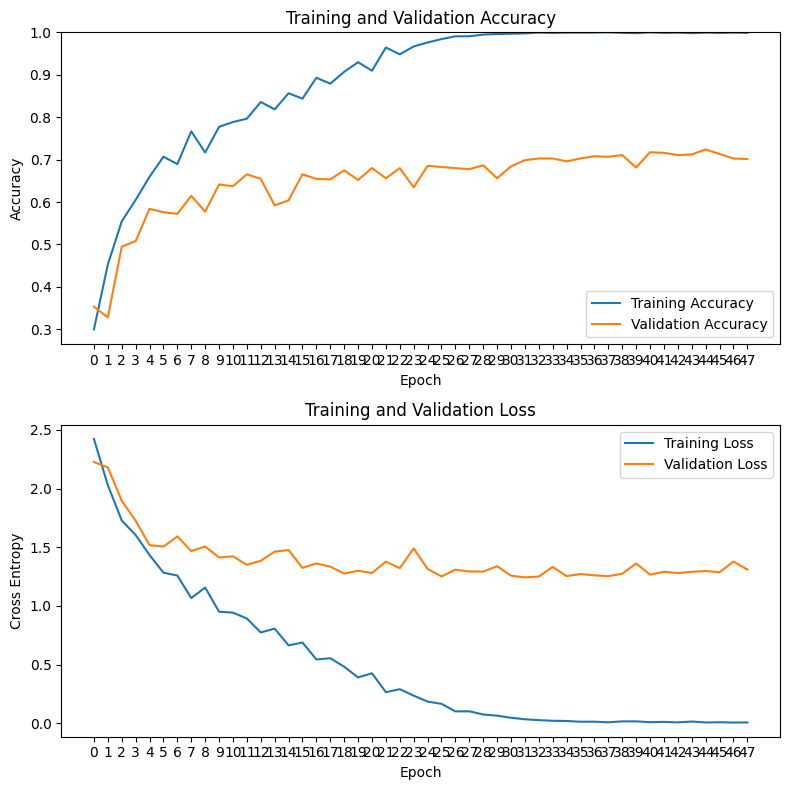

In [21]:
train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([min(plt.ylim()),1])
plt.xticks(range(len(train_accuracy)))
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.xticks(range(len(train_loss)))

plt.tight_layout()
plt.show()

In [22]:
test_loss, test_accuracy = model.evaluate(ds_test)
print(f"Test accuracy: {test_accuracy}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 459ms/step - accuracy: 0.7724 - loss: 1.0187
Test accuracy: 0.762666642665863


In [23]:
predictions = model.predict(ds_test)
pred_y = np.argmax(predictions, axis=1)    

24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 474ms/step


In [24]:
print(classification_report(test_y_encoded, pred_y, target_names=list(label_to_index.keys()), digits=4))

                        precision    recall  f1-score   support

         advertisement     0.7692    0.8163    0.7921        49
                budget     0.6522    0.5556    0.6000        54
                 email     0.9500    0.8837    0.9157        43
           file_folder     0.7143    0.9574    0.8182        47
                  form     0.6071    0.6939    0.6476        49
           handwritten     0.8627    0.9362    0.8980        47
               invoice     0.7436    0.6444    0.6905        45
                letter     0.8333    0.8333    0.8333        48
                  memo     0.7647    0.8298    0.7959        47
          news_article     0.7391    0.8095    0.7727        42
          presentation     0.6140    0.7447    0.6731        47
         questionnaire     0.8611    0.6596    0.7470        47
                resume     0.7872    0.8222    0.8043        45
scientific_publication     0.8293    0.7234    0.7727        47
     scientific_report     0.6857    0.

In [25]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = title
        else:
            title = 'Confusion matrix, without normalization'


    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
 
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')


    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")


    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

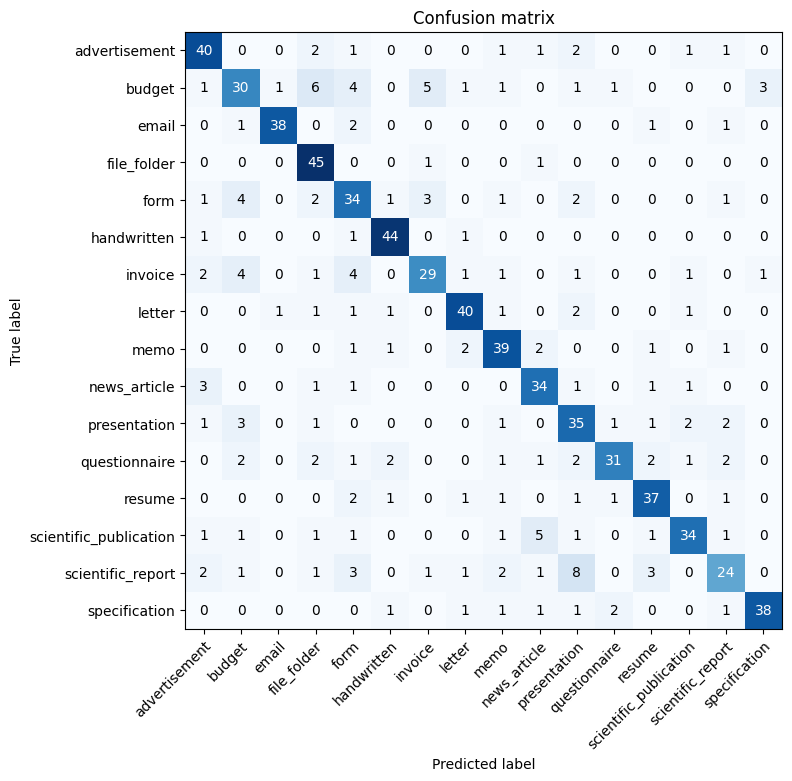

In [27]:
_ = plot_confusion_matrix(test_y_encoded, pred_y, classes=list(label_to_index.keys()), normalize=False, title="Confusion matrix")